In [ ]:
!pip install tensorboard
!pip install -qqq accelerate==0.28.0
!pip install -qqq transformers==4.48.3
!pip install -qqq datasets==3.6.0

!pip install -U accelerate

import os
from google.colab import drive

drive.mount('/content/drive')

zip_file = "/content/drive/MyDrive/ai_term/train.zip"
extract_dir = "data"
train_data_labels_path = os.path.join(extract_dir, "train", "train_labels.csv") 

if not os.path.exists(extract_dir) or not os.path.exists(train_data_labels_path):
    print(f"{extract_dir} 디렉토리 또는 필요한 파일({train_data_labels_path})이 존재하지 않습니다. 압축 해제합니다.")
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)
    !unzip -q {zip_file} -d {extract_dir}
else:
    print(f"{extract_dir} 디렉토리와 필요한 파일이 이미 존재합니다. 압축 해제를 건너뜁니다.")

train_data_labels = train_data_labels_path
train_image_path = os.path.join(extract_dir, "train", "images") + "/"

In [44]:
train_data_labels = "../data/train/train_labels.csv"
train_image_path = "../data/train/images/"

embedding_vector_output_path = "./output/embedding_vector.npy"

fruit_labels = ["apple", "asian pear", "banana", "cherry", "grape", "pineapple"]
style_labels = ["pencil color", "oil painting", "water color"]

In [55]:
from transformers import ViTImageProcessor
from transformers import ViTModel

from PIL import Image

import torch.nn as nn
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

In [46]:
import os
import random

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [47]:
dataset = pd.read_csv(train_data_labels)
print(dataset.head())

train, test = train_test_split(dataset, test_size=0.3, random_state=42)

  file_name  style  fruit
0     0.jpg      0      0
1     1.jpg      0      0
2     2.jpg      0      0
3     3.jpg      0      0
4     4.jpg      0      0


In [48]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: mps


In [49]:
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTModel.from_pretrained("google/vit-base-patch16-224")
model.to(device)

model.eval()

embeddings = []

with torch.no_grad():
    for _, data in train.iterrows():
        img_path = os.path.join(train_image_path, data["file_name"])
        img = Image.open(img_path).convert("RGB")

        inputs = feature_extractor(images=img, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        outputs = model(**inputs)
        emb = outputs.last_hidden_state[:, 0].squeeze().cpu().numpy()
        embeddings.append(emb)

embeddings = np.stack(embeddings)
np.save(embedding_vector_output_path, embeddings)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
top_k = 5

train_embeddings = np.load(embedding_vector_output_path)

train_fruit_labels = train["fruit"].tolist()
train_style_labels = train["style"].tolist()

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [51]:
true_fruit, pred_fruit = [], []
true_style, pred_style = [], []

for _, row in test.iterrows():
    img_path = os.path.join(train_image_path, row["file_name"])
    fruit_label = row["fruit"]
    style_label = row["style"]

    true_fruit.append(fruit_label)
    true_style.append(style_label)

    img = Image.open(img_path).convert("RGB")
    inputs = feature_extractor(images=img, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        emb = model(**inputs).last_hidden_state[:, 0].squeeze().cpu().numpy()

    similarities = [cosine_similarity(emb, train_emb) for train_emb in train_embeddings]
    topk_indices = np.argsort(similarities)[::-1][:top_k]

    topk_fruit = [train_fruit_labels[i] for i in topk_indices]
    topk_style = [train_style_labels[i] for i in topk_indices]

    pred_fruit = fruit_label if fruit_label in topk_fruit else topk_fruit[0]
    pred_style = style_label if style_label in topk_style else topk_style[0]

    pred_fruit.append(pred_fruit)
    pred_style.append(pred_style)

In [52]:
def evaluate(y_true, y_pred, label=""):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    rec = recall_score(y_true, y_pred, average="macro")
    print(f"[{label}] Top-{top_k} Accuracy: {acc:.4f}, F1: {f1:.4f}, Recall: {rec:.4f}")

evaluate(true_fruit, pred_fruit, "FRUIT")
evaluate(true_style, pred_style, "STYLE")

[FRUIT] Top-5 Accuracy: 0.9972, F1: 0.9973, Recall: 0.9973
[STYLE] Top-5 Accuracy: 0.9963, F1: 0.9963, Recall: 0.9963


In [59]:
def draw_two_confusion_matrix(first_label, first_conf_matrix, first_classes, second_label, second_conf_matrix, second_classes):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.heatmap(first_conf_matrix, annot=True, fmt="d", cmap="YlGnBu",
                xticklabels=first_classes, yticklabels=first_classes, ax=axes[0])
    axes[0].set_title(f"Confusion Matrix: {first_label}")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    sns.heatmap(second_conf_matrix, annot=True, fmt="d", cmap="YlOrBr",
                xticklabels=second_classes, yticklabels=second_classes, ax=axes[1])
    axes[1].set_title(f"Confusion Matrix: {second_label}")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

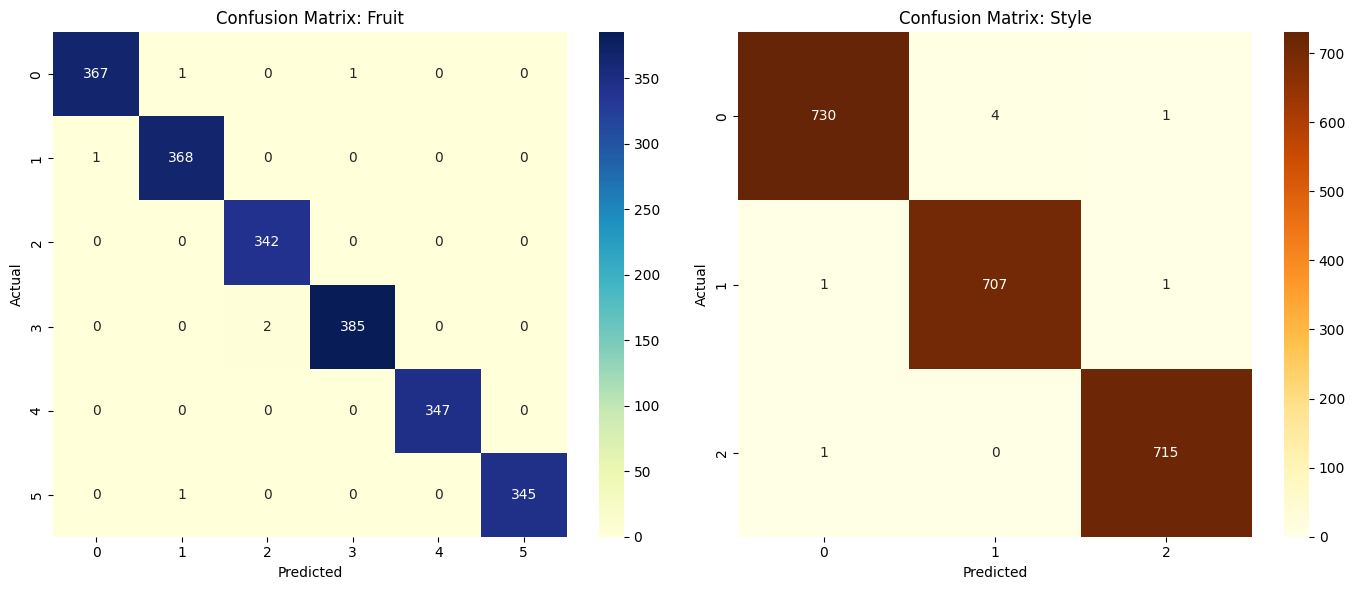

In [ ]:
fruit_classes = sorted(set(dataset["fruit"]))
style_classes = sorted(set(dataset["style"]))

fruit_conf_matrix = confusion_matrix(true_fruit, pred_fruit)
style_conf_matrix = confusion_matrix(true_style, pred_style)

draw_two_confusion_matrix("Fruit", fruit_conf_matrix, fruit_classes, "Style", style_conf_matrix, style_classes)